In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import PIL
import os
import pandas as pd
from sklearn.cluster import SpectralClustering
from tqdm import tqdm

In [2]:
root_path = "/mnt/pentagon/xul076/sketchy/familiar/"
test_meta = pd.read_csv("./sketchy_fam_meta.csv", index_col=0)

In [3]:
test_meta

,class,photo_path,sketch_path,split
0,pantheon,pantheon_photo.jpg,pantheon_sketch.jpg,fam
1,moon,moon_photo.jpg,moon_sketch.jpg,fam
2,bridge,bridge_photo.jpg,bridge_sketch.jpg,fam


In [4]:
sketch_files = list(test_meta["sketch_path"])
sketch_files = [os.path.join(root_path, x) for x in sketch_files]

In [5]:
def close(thresh):
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    fill = cv2.fillPoly(thresh, contours, 255)
    thresh = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9)))
    return thresh

  0%|                                          | 0/3 [00:00<?, ?it/s]

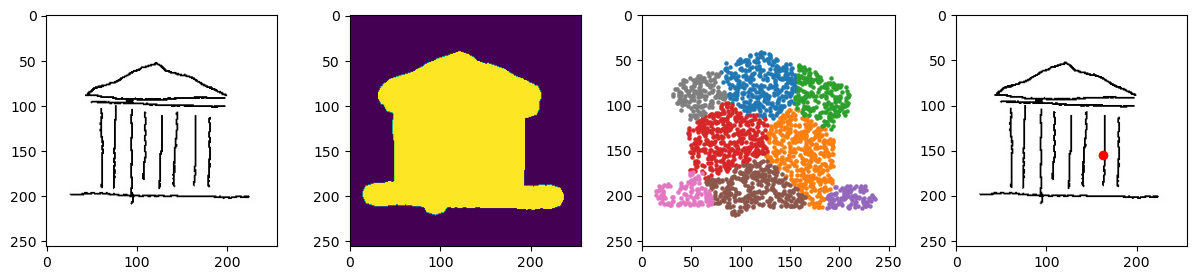

 33%|███████████▎                      | 1/3 [00:00<00:01,  1.28it/s]

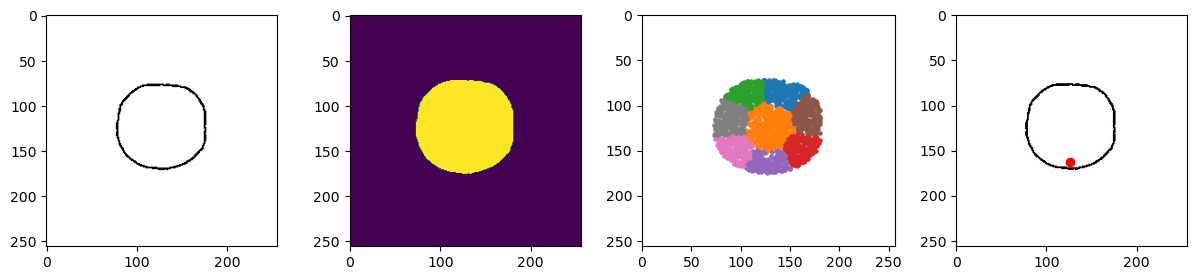

 67%|██████████████████████▋           | 2/3 [00:01<00:00,  1.04it/s]

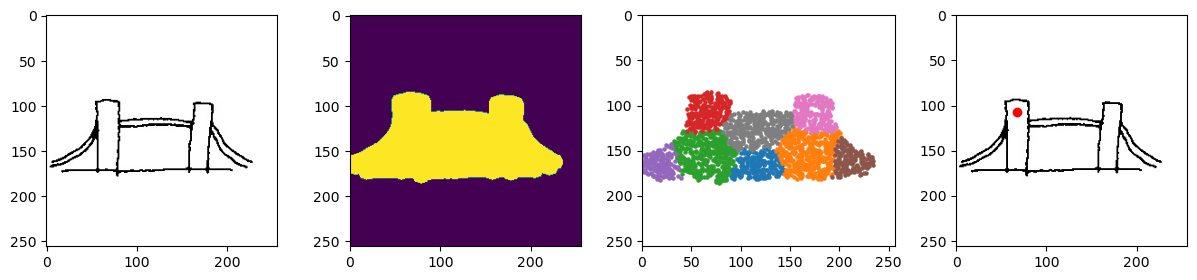

100%|██████████████████████████████████| 3/3 [00:02<00:00,  1.15it/s]


In [21]:
centerss = []
kp_selection = [1, 4, 3]
idx = 0
np.random.seed(0)
cluster = SpectralClustering(8, affinity="nearest_neighbors", random_state=0)
for sketch_file in tqdm(sketch_files):
    img = np.array(PIL.Image.open(sketch_file))
    fig, axes = plt.subplots(1, 4, figsize=(15, 3))
    axes[0].imshow(img)

    img_ = 255 - img[:, :, 0]
    ret, thresh = cv2.threshold(img_, 127, 255, 0)
    closure = False
    while not closure:
        thresh = close(thresh)
        contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        if len(contours) == 1:
            closure = True
    thresh = thresh / 255
    axes[1].imshow(thresh)

    x, y = np.where(thresh == 1)
    pins = np.stack([x, y], axis=0).T

    if len(pins) < 2048:
        continue

    select = np.random.choice(len(pins), 2048, replace=False)
    pins = pins[select]

    splits = cluster.fit_predict(pins)
    centers = []

    for i in range(8):
        # img_ = img.copy()
        pin_split = pins[splits==i]
        axes[2].scatter(pin_split[:, 1], pin_split[:, 0], s=5)
        center = pin_split.mean(axis=0)
#         img_ = cv2.circle(img_, (int(center[1]), int(center[0])), 3, (0, 0, 255), thickness=-1, lineType=cv2.LINE_AA)

#         plt.imshow(img_)
#         plt.show()
        if i == kp_selection[idx]:
            centers.append(center)
    idx += 1
    axes[2].set_ylim(0, 256)
    axes[2].set_xlim(0, 256)
    axes[2].invert_yaxis()
    centers = np.array(centers)
    axes[3].imshow(img)
    axes[3].scatter(centers[:, 1], centers[:, 0], c="red")
    axes[3].set_ylim(0, 256)
    axes[3].set_xlim(0, 256)
    axes[3].invert_yaxis()
    plt.show()
    centerss.append(centers)

In [22]:
center_list = np.array(centerss)
center_list.shape

(3, 1, 2)

In [23]:
keypoint_meta = pd.DataFrame(columns = [*test_meta.columns, "keypoint_x", "keypoint_y", "keypoint_idx"])
for i in tqdm(range(len(center_list))):
    kps = center_list[i]
    row = list(test_meta.loc[i])
    for j in range(len(kps)):
        kp = kps[j]
        kp_row = row + [kp[0], kp[1], j]
        keypoint_meta.loc[i * 8 + j] = kp_row

100%|██████████████████████████████████| 3/3 [00:00<00:00, 33.59it/s]


In [38]:
keypoint_meta.to_csv(os.path.join(root_path, "../sketchy_catch_keypoint_meta.csv"))
keypoint_meta.to_csv(os.path.join("./sketchy_catch_keypoint_meta.csv"))

In [36]:
keypoint_meta

,class,photo_path,sketch_path,split,keypoint_x,keypoint_y,keypoint_idx
0,leaf,leaf_photo.jpg,leaf_sketch.jpg,catch,175.624242,113.000000,0
8,sun,sun_photo.jpg,sun_sketch.jpg,catch,99.835165,114.620879,0
16,opera,opera_photo.jpg,opera_sketch.jpg,catch,142.543307,70.031496,0
24,eiffel,eiffel_photo.jpg,eiffel_sketch.jpg,catch,188.201970,183.763547,0
32,sunflower,sunflower_photo.jpg,sunflower_sketch.jpg,catch,134.367089,122.810127,0
